In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Load pre-processed data
Poore_BRCA = pd.read_csv("Poore_BRCA", index_col=0)
Poore_BRCA

,g__Cobetia,g__Ammonifex,g__Owenweeksia,g__Haloplasma,g__Desulfosarcina,g__Asaia,g__Parvibaculum,g__Neosynechococcus,g__Zymomonas,g__Kutzneria,...,portion_weight,aliquot_concentration,analyte_A260A280Ratio,analyte_amount,analyte_type_label,radiation_therapy_code_label,radiation_therapy_site_label,radiation_therapy_type_label,year_of_diagnosis,vital_status_label
sample_id1,,,,,,,,,,,,,,,,,,,,,
s6501,1.103111,2.393026,1.924050,0.679874,2.855614,1.458905,3.822917,1.950597,-0.154784,1.056188,...,130.0,0.17,1.83,40.77,RNA,22C40DCA-0F16-42B4-A28F-29FEAC78B565,Primary Tumor Field,External,2006.0,Alive
s6522,1.479929,2.791636,3.893348,1.100076,1.041926,1.840587,1.874406,2.362581,0.172999,-0.146590,...,30.0,0.13,1.78,11.94,RNA,NaN,NaN,NaN,2006.0,Alive
s6459,1.829156,1.794873,1.326145,-1.380102,1.031621,1.028514,0.890885,2.840755,1.436739,2.453363,...,30.0,0.08,2.03,77.70,DNA,NaN,NaN,NaN,2008.0,Alive
s6574,1.925188,2.057109,1.619184,1.862043,1.877224,0.605902,1.251608,1.261155,-0.685010,2.859029,...,30.0,0.16,1.82,5.14,RNA,4B8B651E-F54C-4EB0-AC3F-BFEFB8E3BF05,Regional site,External,2001.0,Alive
s6538,4.256201,2.029458,1.700561,0.391692,1.804504,3.777331,5.799079,1.599825,-0.371001,3.242951,...,40.0,0.17,1.84,22.61,RNA,CF613056-FC7D-4604-89E3-ABBBC28E70AD,Primary Tumor Field,External,2008.0,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s6812,0.347136,2.064020,1.626095,0.283991,1.703563,2.197776,1.258519,1.268067,-0.678099,1.972855,...,30.0,0.15,1.84,48.65,RNA,B0A03CE9-A77F-43D8-8C34-8F37099E4531,Primary Tumor Field,EXTERNAL BEAM,2010.0,Alive
s6761,-0.265530,2.306996,1.883595,2.950444,1.731282,1.040480,1.514738,1.401018,1.890969,1.902507,...,30.0,0.09,1.83,75.68,DNA,45D50414-CE7E-456B-BB0F-D49E70BB491D,Not available,Not available,2010.0,Alive
s6831,3.630990,2.289707,1.624344,0.509342,0.820343,3.608684,1.215478,4.027831,1.147350,-0.604633,...,30.0,0.16,1.76,28.56,RNA,NaN,NaN,NaN,1994.0,Dead


In [3]:
class_counts = Poore_BRCA['sample_type'].value_counts()
print(class_counts)

sample_type
Primary Tumor           1238
Solid Tissue Normal      129
Blood Derived Normal     107
Metastatic                 9
Name: count, dtype: int64


In [4]:
Poore_BRCA = Poore_BRCA[Poore_BRCA['sample_type'] != 'Metastatic']
class_counts = Poore_BRCA['sample_type'].value_counts()
print(class_counts)

sample_type
Primary Tumor           1238
Solid Tissue Normal      129
Blood Derived Normal     107
Name: count, dtype: int64


In [5]:
# Prepare features and target variable
X = Poore_BRCA.drop(['gdc_file_uuid', 'filename', 'age_at_diagnosis', 'aliquot_uuid',
       'case_uuid', 'days_to_death', 'disease_type', 'ethnicity',
       'experimental_strategy', 'gender', 'investigation', 'platform',
       'primary_site', 'race', 'reference_genome', 'sample_type',
       'sample_uuid', 'vital_status', 'tissue_source_site_label',
       'data_submitting_center_label', 'country_of_sample_procurement',
       'histological_diagnosis_label', 'pathologic_t_label',
       'pathologic_n_label', 'pathologic_stage_label', 'icd03_histology_label',
       'icd03_histology_site', 'icd10', 'portion_is_ffpe',
       'new_tumor_event_after_initial_trtmt',
       'primary_therapy_outcome_success_label', 'portion_weight',
       'aliquot_concentration', 'analyte_A260A280Ratio', 'analyte_amount',
       'analyte_type_label', 'radiation_therapy_code_label',
       'radiation_therapy_site_label', 'radiation_therapy_type_label',
       'year_of_diagnosis', 'vital_status_label'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled
y = Poore_BRCA['sample_type']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))

Unique values of y: ['Blood Derived Normal' 'Primary Tumor' 'Solid Tissue Normal']
Unique values of y: [0 1 2]


In [6]:
# Oversampling to ensure class balance
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_scaled, y = oversampler.fit_resample(X_scaled,y)
print(X_scaled.shape)
print(y.shape)

(3714, 1170)
(3714,)


Best Parameters: {'alpha': 0.1, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best Score: 0.9799918482288426
Test Set Accuracy: 0.9838565022421525


<Figure size 800x600 with 0 Axes>

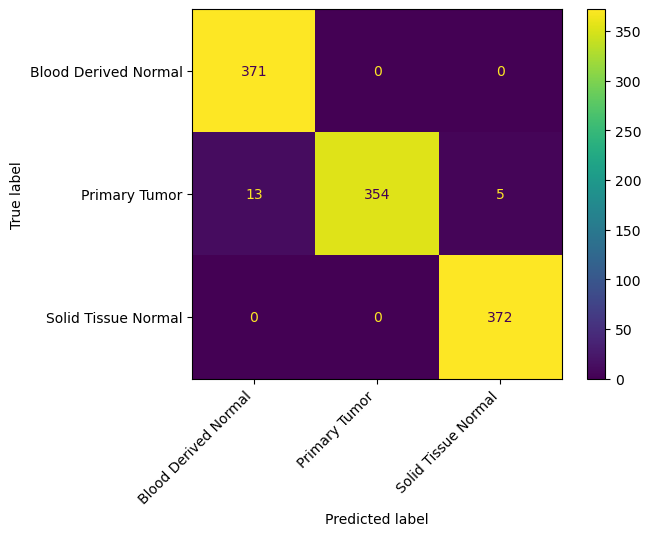

                      precision    recall  f1-score   support

Blood Derived Normal       0.97      1.00      0.98       371
       Primary Tumor       1.00      0.95      0.98       372
 Solid Tissue Normal       0.99      1.00      0.99       372

            accuracy                           0.98      1115
           macro avg       0.98      0.98      0.98      1115
        weighted avg       0.98      0.98      0.98      1115



In [7]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1], # Include L1 regularization
    'n_estimators': [50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', seed=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the model on the test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blood Derived Normal', 'Primary Tumor', 'Solid Tissue Normal'])
plt.figure(figsize=(8, 6))
cm_display.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=['Blood Derived Normal', 'Primary Tumor', 'Solid Tissue Normal'])
print(report)

In [8]:
from sklearn.metrics import roc_auc_score

# Train XGBoost model with best parameters for calculating feature importances
best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', **best_params)
y_score = best_xgb_model.fit(X_train, y_train).predict_proba(X_test)

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
1.00
Macro-averaged One-vs-Rest ROC AUC score:
1.00


C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_9156\3634286834.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=2, color='black', label='Chance level (AUC = 0.5)')


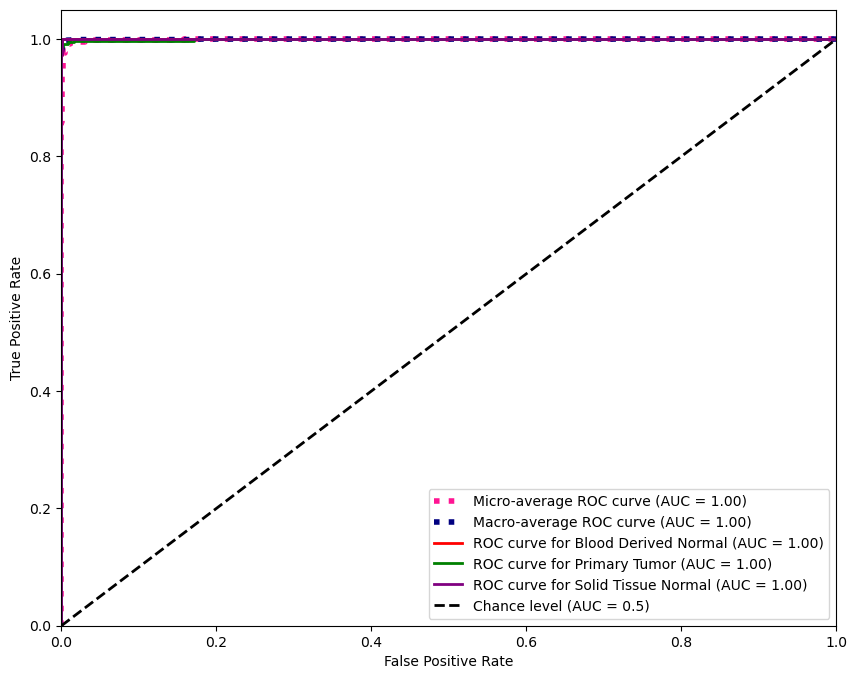

In [9]:
# Binarize the output labels
y_test_binarized = label_binarize(y_test, classes=np.arange(3))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 3

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['red', 'green', 'purple']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve for {0} (AUC = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2, color='black', label='Chance level (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_18284\2875457785.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")


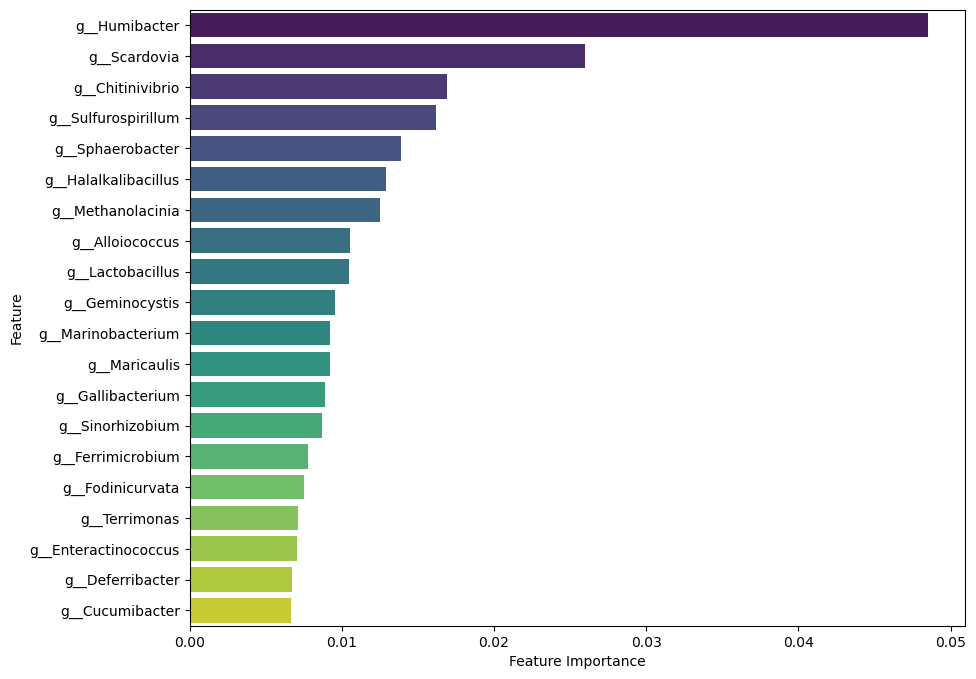

In [10]:
# Train XGBoost model with best parameters for calculating feature importances
best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_20_indices = feature_importances.argsort()[::-1][:20]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

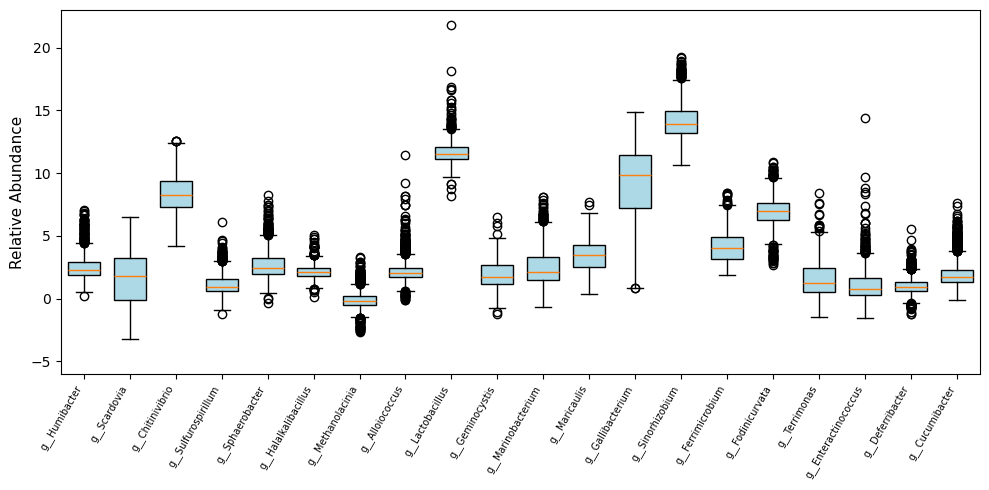

In [13]:
# Box plot for visualizing bacterial relative abundance of 10 most important bacteria

data = {}
top_20_feature_names = feature_names[top_20_indices]
#abundance_scaled = np.log2(X)

for column_name in top_20_feature_names:
    data[column_name] = X[column_name]

plt.figure(figsize=(10, 5))
plt.boxplot(data.values(), widths=0.7, patch_artist=True, 
            boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black'))

plt.ylim(-6, 23)
plt.ylabel('Relative Abundance', fontsize=11)
plt.xticks(range(1, len(data) + 1), data.keys(), rotation=60, ha='right', fontsize=7)
plt.tight_layout()
plt.show()